In [3]:
import torch
import torchvision.datasets
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision import transforms
from utils import *
from gan import GAN

%matplotlib inline

## **1. Model Defining**

In [4]:
class Discriminator(nn.Module):
  def __init__(self, filters, img_channels):
    super(Discriminator, self).__init__()   

    self.conv1 = nn.Conv2d(in_channels=img_channels, out_channels=filters,
                           kernel_size=4, stride=2, padding=1)
    self.l_relu1 = nn.LeakyReLU(0.2)
    
    self.conv2 = nn.Conv2d(filters, filters*2, 4, 2, 1)
    self.bn2 = nn.BatchNorm2d(filters*2)
    self.l_relu2 = nn.LeakyReLU(0.2)

    self.conv3 = nn.Conv2d(filters*2, filters*4, 4, 2, 1)
    self.bn3 = nn.BatchNorm2d(filters*4)
    self.l_relu3 = nn.LeakyReLU(0.2)

    self.conv4 = nn.Conv2d(filters*4, filters*8, 4, 2, 1)
    self.bn4 = nn.BatchNorm2d(filters*8)
    self.l_relu4 = nn.LeakyReLU(0.2)

    self.conv5 = nn.Conv2d(filters*8, 1, 4, 1, 0)
    self.out = nn.Sigmoid()
  

  def forward(self, x):
    x = self.l_relu1(self.conv1(x))
    x = self.l_relu2(self.bn2(self.conv2(x)))
    x = self.l_relu3(self.bn3(self.conv3(x)))
    x = self.l_relu4(self.bn4(self.conv4(x)))
    x = self.conv5(x)
    x = self.out(x)

    return x

    
class Generator(nn.Module):
  def __init__(self, filters, img_channels, latent_dimension=100):
    super(Generator, self).__init__()

    self.deconv1 = nn.ConvTranspose2d(in_channels=latent_dimension, out_channels=filters*8,
                                      kernel_size=4, stride=1, padding=0)
    self.bn1 = nn.BatchNorm2d(filters*8)
    self.relu1 = nn.ReLU()

    self.deconv2 = nn.ConvTranspose2d(filters*8, filters*4, 4, 2, 1)
    self.bn2 = nn.BatchNorm2d(filters*4)
    self.relu2 = nn.ReLU()

    self.deconv3 = nn.ConvTranspose2d(filters*4, filters*2, 4, 2, 1)
    self.bn3 = nn.BatchNorm2d(filters*2)
    self.relu3 = nn.ReLU()

    self.deconv4 = nn.ConvTranspose2d(filters*2, filters, 4, 2, 1)
    self.bn4 = nn.BatchNorm2d(filters)
    self.relu4 = nn.ReLU()

    self.deconv5 = nn.ConvTranspose2d(filters, img_channels, 4, 2, 1)
    self.out = nn.Tanh()


  def forward(self, x):
    x = self.relu1(self.bn1(self.deconv1(x)))
    x = self.relu2(self.bn2(self.deconv2(x)))
    x = self.relu3(self.bn3(self.deconv3(x)))
    x = self.relu4(self.bn4(self.deconv4(x)))
    x = self.out(self.deconv5(x))

    return x

    
def weights_init(network):
  for module in network.modules():
    if isinstance(module, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
      nn.init.normal_(module.weight.data, mean=0.0, std=0.02)

## **2. Training on Fashion-MNIST**

In [71]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Resize(64), transforms.Normalize(0.5, 0.5)])

fashion_mnist = datasets.FashionMNIST('./fashion_mnist', train=True, transform=transform, download=True)

batch_size = 128
train_loader = torch.utils.data.DataLoader(fashion_mnist, batch_size=batch_size, shuffle=True)

In [146]:
img_dim = 64
latent_dim = 100

discriminator = Discriminator(filters=64, img_channels=1)
generator = Generator(filters=32, img_channels=1, latent_dimension=latent_dim)

weights_init(discriminator)
weights_init(generator)

fashion_gan = GAN(img_dim, latent_dim)
fashion_gan.discriminator = discriminator
fashion_gan.generator = generator

criterion = nn.BCELoss()

discr_optim = optim.Adam(discriminator.parameters(), lr=2e-4, betas=(0.5, 0.999))
gene_optim = optim.Adam(generator.parameters(), lr=2e-4, betas=(0.5, 0.999))

epochs = 20
test_noise = torch.randn(5, 100, 1, 1)

In [ ]:
epoch_images = []

for epoch in range(epochs):
  
  discr_epoch_loss, gene_epoch_loss = train_gan(fashion_gan, discr_optim, gene_optim,
                                                criterion, train_loader, on_images=True)
  
  if (epoch+1) % 2 == 0:
    print(f"\nLoss in epoch {epoch+1}:")
    print(f"Discriminator - {discr_epoch_loss}")
    print(f"Generator - {gene_epoch_loss}")

    with torch.no_grad():
      fashion_gan.cpu()
      epoch_images.append(fashion_gan.generator(test_noise))

      if torch.cuda.is_available():
        fashion_gan.cuda()

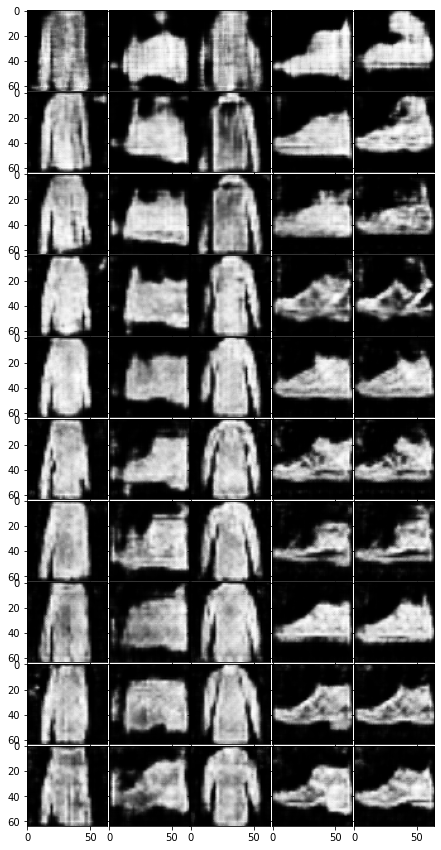

In [148]:
epoch_images = torch.cat(epoch_images)

fig = plt.figure(figsize=(15, 15))
grid = ImageGrid(fig, 111, (10, 5))

for ax, img in zip(grid, epoch_images):
  ax.imshow(img.squeeze(), cmap='gray')

## **3. Training on CIFAR-10**

In [ ]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Resize(64),
                                transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])
batch_size = 128
train_loader, test_loader = load_data(dataset='cifar10', transform=transform, batch_size=batch_size)

In [20]:
img_dim = 64
latent_dim = 100

discriminator = Discriminator(filters=64, img_channels=3)
generator = Generator(filters=64, img_channels=3, latent_dimension=latent_dim)

cifar_gan = GAN(img_dim, latent_dim)
cifar_gan.discriminator = discriminator
cifar_gan.generator = generator

weights_init(discriminator)
weights_init(generator)

criterion = nn.BCELoss()

discr_optim = optim.Adam(discriminator.parameters(), lr=2e-4, betas=(0.5, 0.999))
gene_optim = optim.Adam(generator.parameters(), lr=2e-4, betas=(0.5, 0.999))

epochs = 100

test_noise = torch.randn(5, latent_dim, 1, 1)

In [ ]:
epoch_images = []

for epoch in range(epochs):
  
  discr_epoch_loss, gene_epoch_loss = train_gan(cifar_gan, discr_optim, gene_optim,
                                                criterion, train_loader, on_images=True)
  
  if (epoch+1) % 2 == 0:
    print(f"\nLoss in epoch {epoch+1}:")
    print(f"Discriminator - {discr_epoch_loss}")
    print(f"Generator - {gene_epoch_loss}")

    with torch.no_grad():
      cifar_gan.cpu()
      epoch_images.append(cifar_gan.generator(test_noise))

      if torch.cuda.is_available():
        generator.cuda()

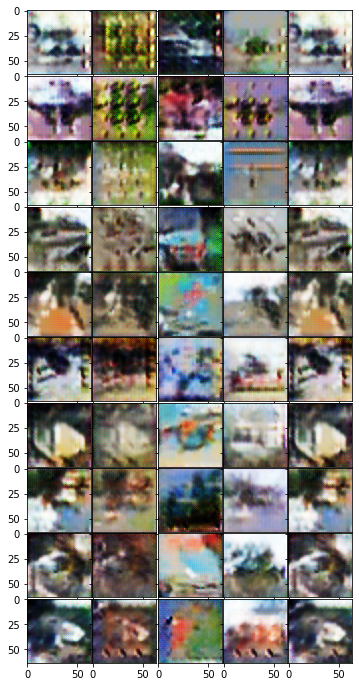

In [29]:
fig = plt.figure(figsize=(12, 12))
grid = ImageGrid(fig, 111, (10, 5))

scaling_factor = torch.Tensor([0.5, 0.5, 0.5]).reshape(1, 1, 3) # Un-normalizing tensor

for ax, img in zip(grid, torch.cat(epoch_images[30:])):
  img = img.clone().permute(1, 2, 0)
  img *= scaling_factor
  img += scaling_factor
  ax.imshow(img)